In [5]:
import importlib
from utils import graph_perturb

In [13]:
from datasets import load_mutag, load_proteins

mutag_data = load_mutag()
protein_data = load_proteins()

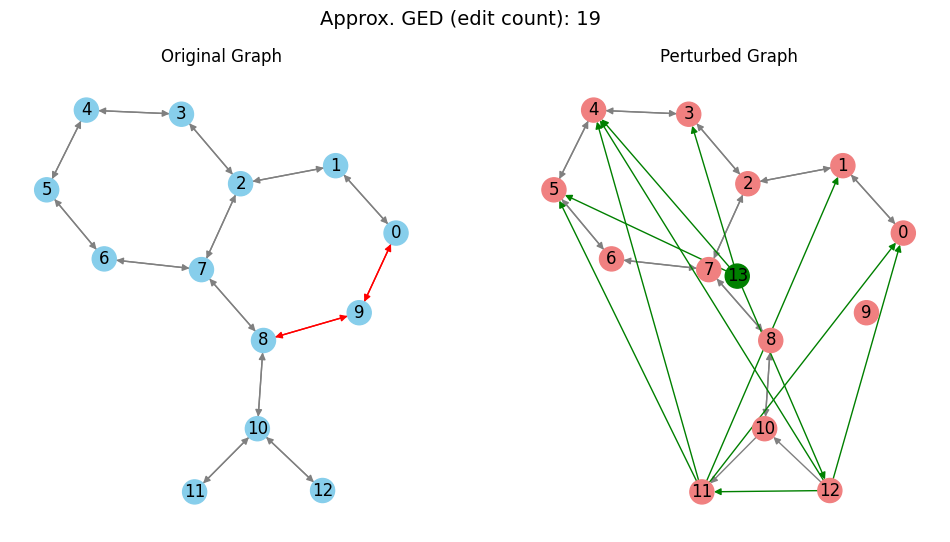

In [64]:
importlib.reload(graph_perturb)
from utils.graph_perturb import generate_perturbed_pairs, plot_graph_pair

mutag_ged_data = generate_perturbed_pairs(mutag_data, n_perturbations=5)

plot_graph_pair(mutag_ged_data[5][0], mutag_ged_data[5][1], mutag_ged_data[5][2])

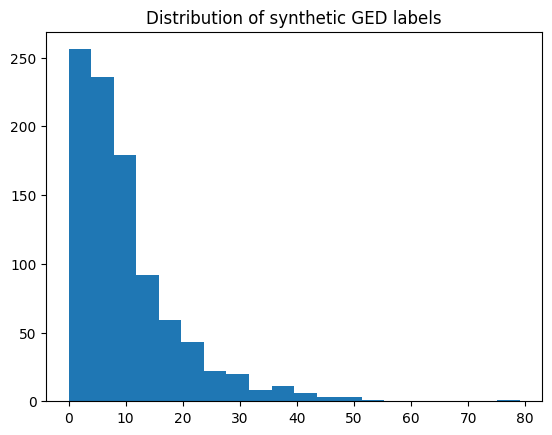

In [62]:
import matplotlib.pyplot as plt

ged_values = [g for _, _, g in mutag_ged_data]
plt.hist(ged_values, bins=20)
plt.title("Distribution of synthetic GED labels")
plt.show()


In [12]:
import sys, os
# go up to the repo root (adjust number of ../ as needed)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)
print("✅ Added repo root to sys.path:", repo_root)

import torch
from torch_geometric.loader import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx

from src.datasets.mutag import load_mutag
from src.models.explainee_gnn import ExplaineeGIN
from src.models.generator import GraphGenerator
from src.models.adapter import GeneratorAdapter

✅ Added repo root to sys.path: /repo/new-dist


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = load_mutag()
num_classes = 2
loader = DataLoader(dataset, batch_size=1, shuffle=False)
# Load trained explainee
explainee_ckpt = Path("/repo/new-dist/models/explainees/gin_mutag.pt")
explainee = ExplaineeGIN(
    in_dim=dataset[0].x.size(1),
    hidden_dim=32,
    num_layers=2,
    dropout=0.2,
    num_classes=num_classes,
)
explainee.load_state_dict(torch.load(explainee_ckpt, map_location=device))
explainee = explainee.to(device).eval()


/tmp/ipykernel_21246/2861355751.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  explainee.load_state_dict(torch.load(explainee_ckpt, map_location=device))


28

In [25]:
# Load both generators (one per class)
gen_paths = [
    Path("/repo/new-dist/models/generators/generator_class0.pt"),
    Path("/repo/new-dist/models/generators/generator_class1.pt"),
]

adapter = GeneratorAdapter(dataset)

generators = []
for path in gen_paths:
    gen = GraphGenerator(
        max_nodes=620,
        num_cont_node_feats=adapter.num_cont_node_feats,
        dis_node_blocks=[3],
        num_cont_edge_feats=adapter.num_cont_edge_feats,
        dis_edge_blocks=adapter.dis_edge_blocks,
        batch_size=1
    )
    gen.load_state_dict(torch.load(path, map_location=device), strict=False)
    gen.to(device)
    gen.eval()
    generators.append(gen)
    print(f"✅ Loaded {path.name}")


✅ Loaded generator_class0.pt
✅ Loaded generator_class1.pt


/tmp/ipykernel_21246/580048023.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load(path, map_location=device), strict=False)


IndexError: index 0 is out of bounds for axis 1 with size 0

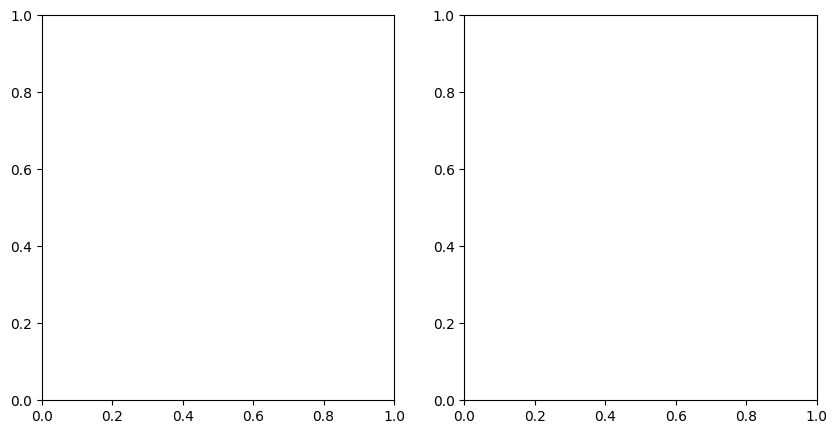

In [26]:
explainee.eval()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, gen in enumerate(generators):
    out = gen()
    adj = out["adj"].squeeze(0).detach().cpu().numpy()
    X = out["cont_node"].squeeze(0).detach().cpu().numpy()

    # Build a NetworkX graph
    G = nx.from_numpy_array(adj > 0.5)
    pos = nx.spring_layout(G, seed=42)

    nx.draw(G, pos, node_color=X[:, 0], cmap="coolwarm",
            with_labels=True, ax=axes[i])
    axes[i].set_title(f"Generated Graph (Target Class {i})")

plt.tight_layout()
plt.show()


In [27]:
from torch_geometric.data import Data

def pyg_from_gen_out(out):
    adj = out["adj"].squeeze(0)
    edge_index = (adj > 0.5).nonzero(as_tuple=False).t()
    x = out["cont_node"].squeeze(0)
    return Data(x=x, edge_index=edge_index)

for i, gen in enumerate(generators):
    out = gen()
    data = pyg_from_gen_out(out).to(device)
    pred = explainee(data.x, data.edge_index, torch.zeros(data.x.size(0), dtype=torch.long, device=device))
    pred_class = pred.softmax(dim=-1).argmax().item()
    print(f"Generator for class {i} → explainee predicted class: {pred_class}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (620x0 and 7x32)

In [28]:
from src.utils.embeddings import compute_classwise_means

loader = DataLoader(dataset, batch_size=8, shuffle=False)
means = compute_classwise_means(explainee, loader, device, num_classes=2)

for layer, class_embeds in means.items():
    print(f"\nLayer {layer}")
    for cls, emb in class_embeds.items():
        print(f"  class={cls}, mean embedding norm={emb.norm().item():.4f}")



Layer layers.0.nn.0


AttributeError: 'Tensor' object has no attribute 'items'